In [2]:
import numpy as np
import matplotlib.pyplot as plt

STATES=[0,1,2,3]
ACTIONS=[0,1] #left,right

def step(s,a):
    
    if s==0 or s==2:
        if a==1:
            s_=s+1
        else:
            s_=max(0,s-1)
    else: #s==1
        if a==1:
            s_=s-1
        else:
            s_=s+1
            
    if s_==3:
        return s_,0,True
    else:
        return s_,-1,False
            
START=0

s=START

step(0,0)

(0, -1, False)

In [3]:
step(0,1)

(1, -1, False)

In [4]:
step(1,0)

(2, -1, False)

In [5]:
step(1,1)

(0, -1, False)

In [6]:
step(2,0)

(1, -1, False)

In [7]:
step(2,1)

(3, 0, True)

In [9]:
def v0(p):

    return (2 * p - 4) / (p * (1 - p))

Text(0.5, 0, 'probability of choosing right action')

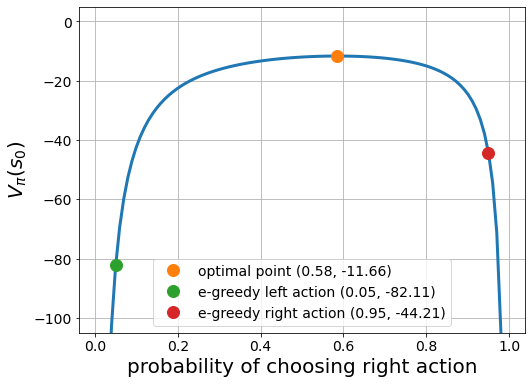

In [39]:
p = np.linspace(0.01, 0.99, 100)
v = true_value(p)

oppi = np.argmax(v)
p_op = p[oppi]
v_op = v[oppi]

plt.rcParams['font.size']='14'
plt.figure(figsize=(8,6))
plt.plot(p, v, linewidth=3)
plt.plot(p_op, v_op, 'o',markersize=12,label="optimal point ({0:.2f}, {1:.2f})".format(p_op, v_op))
plt.ylim(ymin=-105.0, ymax=5)

epsilon = 0.05

plt.plot(epsilon, true_value(epsilon), 'o',markersize=12, 
         label="e-greedy left action ({0:.2f}, {1:.2f})".format(epsilon, true_value(epsilon)))
plt.plot(1-epsilon, true_value(1-epsilon), 'o',markersize=12, 
         label="e-greedy right action ({0:.2f}, {1:.2f})".format(1-epsilon, true_value(1-epsilon)))
plt.legend()
plt.grid()
plt.ylabel('$V_{\pi}(s_0)$',fontsize=20)
plt.xlabel('probability of choosing right action',fontsize=20)

#ax.set_ylabel("Value of the first state")
#ax.set_xlabel("Probability of the action 'right'")
#ax.set_title("Short corridor with switched actions")
#ax.set_ylim(ymin=-105.0, ymax=5)
#ax.legend()
#ax.grid()

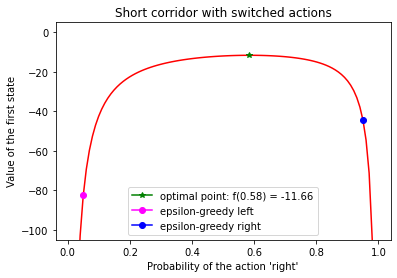

In [20]:
epsilon = 0.05
fig, ax = plt.subplots(1, 1)

# Plot a graph
p = np.linspace(0.01, 0.99, 100)
y = true_value(p)
ax.plot(p, y, color='red')

# Find a maximum point, can also be done analytically by taking a derivative
imax = np.argmax(y)
pmax = p[imax]
ymax = y[imax]
ax.plot(pmax, ymax, color='green', marker="*", label="optimal point: f({0:.2f}) = {1:.2f}".format(pmax, ymax))

# Plot points of two epsilon-greedy policies
ax.plot(epsilon, true_value(epsilon), color='magenta', marker="o", label="epsilon-greedy left")
ax.plot(1 - epsilon, true_value(1 - epsilon), color='blue', marker="o", label="epsilon-greedy right")

ax.set_ylabel("Value of the first state")
ax.set_xlabel("Probability of the action 'right'")
ax.set_title("Short corridor with switched actions")
ax.set_ylim(ymin=-105.0, ymax=5)
ax.legend()